In [2]:
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import torch
import torch.utils.data
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from scripts.traffic_sign_cnn.traffic_sign_cnn import TrafficSignDataset
from scripts.traffic_sign_cnn.labels import id_label
import pickle

In [5]:
#File names
training_name = "D:/data/traffic-signs-data/train.p"
validation_name= "D:/data/traffic-signs-data/valid.p"
testing_name = "D:/data/traffic-signs-data/test.p"

#Load from file to variable
with open(testing_name, mode='rb') as f:
    tst = pickle.load(f)
with open(training_name, mode='rb') as f:
    trn = pickle.load(f)
with open(validation_name, mode='rb') as f:
    vld = pickle.load(f)

#Load features to X and labels to Y
X_tst, Y_tst = tst['features'], tst['labels']
X_trn, Y_trn = trn['features'], trn['labels']
X_vld, Y_vld = vld['features'], vld['labels']

print(X_trn.shape)
print(Y_trn.shape)
print(type(Y_trn))
train_number = X_trn.shape[0]
validation_number = X_vld.shape[0]
test_number = X_tst.shape[0]
image_dimension = X_trn.shape[1:]
classes_number = len(set(Y_trn))
print("Training set : ", train_number) 
print("Testing set : ", test_number)
print("Validation set : ", validation_number)
print("Image data dimensions : ", image_dimension)
print("Classes : ", classes_number)

(34799, 32, 32, 3)
(34799,)
<class 'numpy.ndarray'>
Training set :  34799
Testing set :  12630
Validation set :  4410
Image data dimensions :  (32, 32, 3)
Classes :  43


[13, 82, 406, 682, 207, 639, 646, 417, 560, 431, 54, 409, 245, 390, 174, 476]


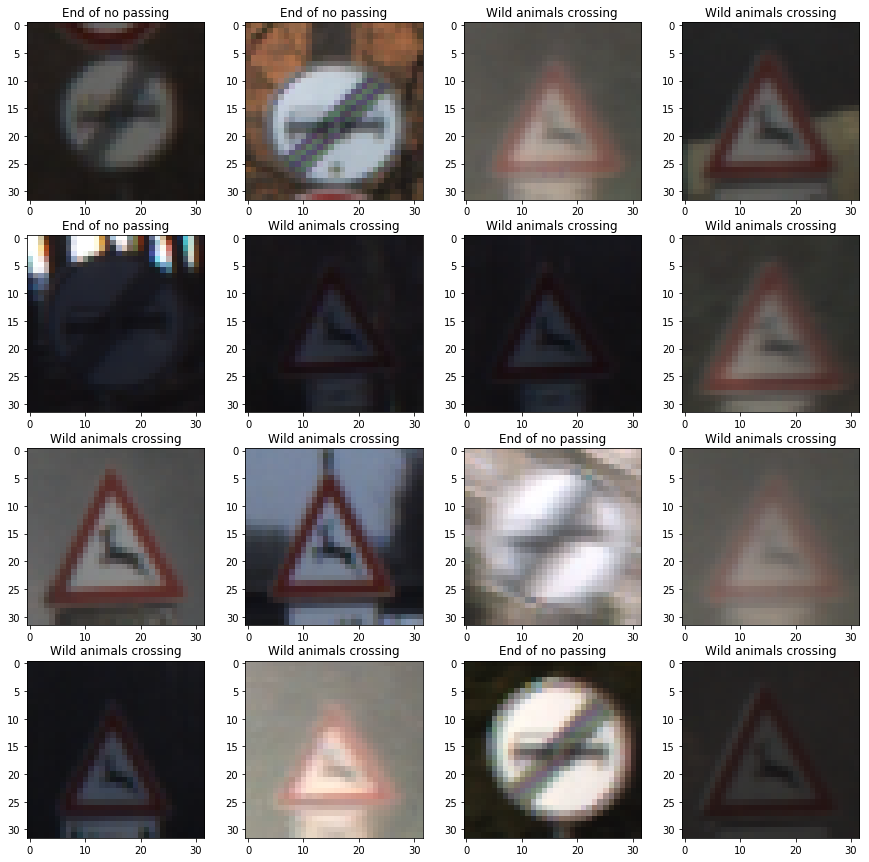

In [6]:
# Configure maplotlib to show visualizations in the notebook.
%matplotlib inline
block = 4
#Get random indexes from train set list
random_index_list = [random.randint(0, 700) for _ in range(block * block)]
print(random_index_list)
#Prepare and plot images
fig = plt.figure(figsize=(15, 15))
plt.rcParams["axes.grid"] = False
for i, index in enumerate(random_index_list):
    a=fig.add_subplot(block, block, i+1)
    imgplot = plt.imshow(X_trn[index])
    a.set_title('%s' % id_label[Y_trn[index]])
    
plt.show()

In [20]:
batch_size=100

In [85]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(), # randomly flip and rotate
#     transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# convert data to a normalized torch.FloatTensor
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Speed limit (30km/h)


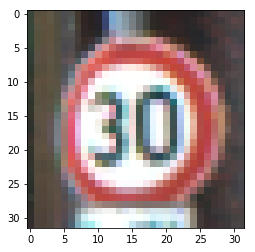

In [87]:
test_data = TrafficSignDataset(X_tst,Y_tst,transform=test_transform)
print(id_label[int(test_data.__getitem__(1)[1])])
imshow(test_data.__getitem__(1)[0])

Go straight or right


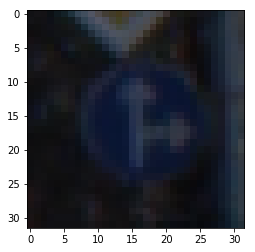

In [88]:
train_data = TrafficSignDataset(X_trn,Y_trn,transform=transform)
print(id_label[int(train_data.__getitem__(1000)[1])])
imshow(train_data.__getitem__(1000)[0])

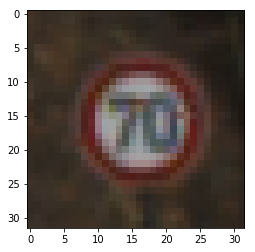

In [89]:
valid_data = TrafficSignDataset(X_vld,Y_vld,transform=transform)
image,label = valid_data.__getitem__(1000)
imshow(image)

In [90]:
# number of subprocesses to use for data loading
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_idx = list(range(train_number))
train_sampler = SubsetRandomSampler(train_idx)
valid_idx = list(range(validation_number))
valid_sampler = SubsetRandomSampler(valid_idx)
test_idx = list(range(test_number))
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler,batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, sampler=valid_sampler,batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, sampler=test_sampler,batch_size=batch_size,  num_workers=num_workers)

1


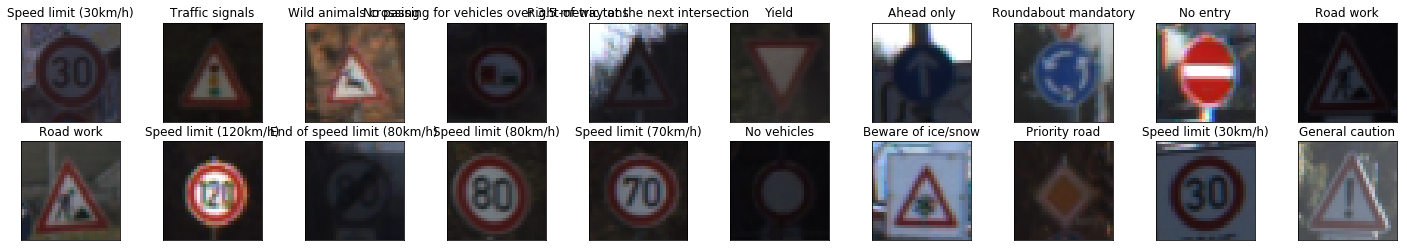

In [91]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(int(labels[0]))
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(id_label[int(labels[idx])])

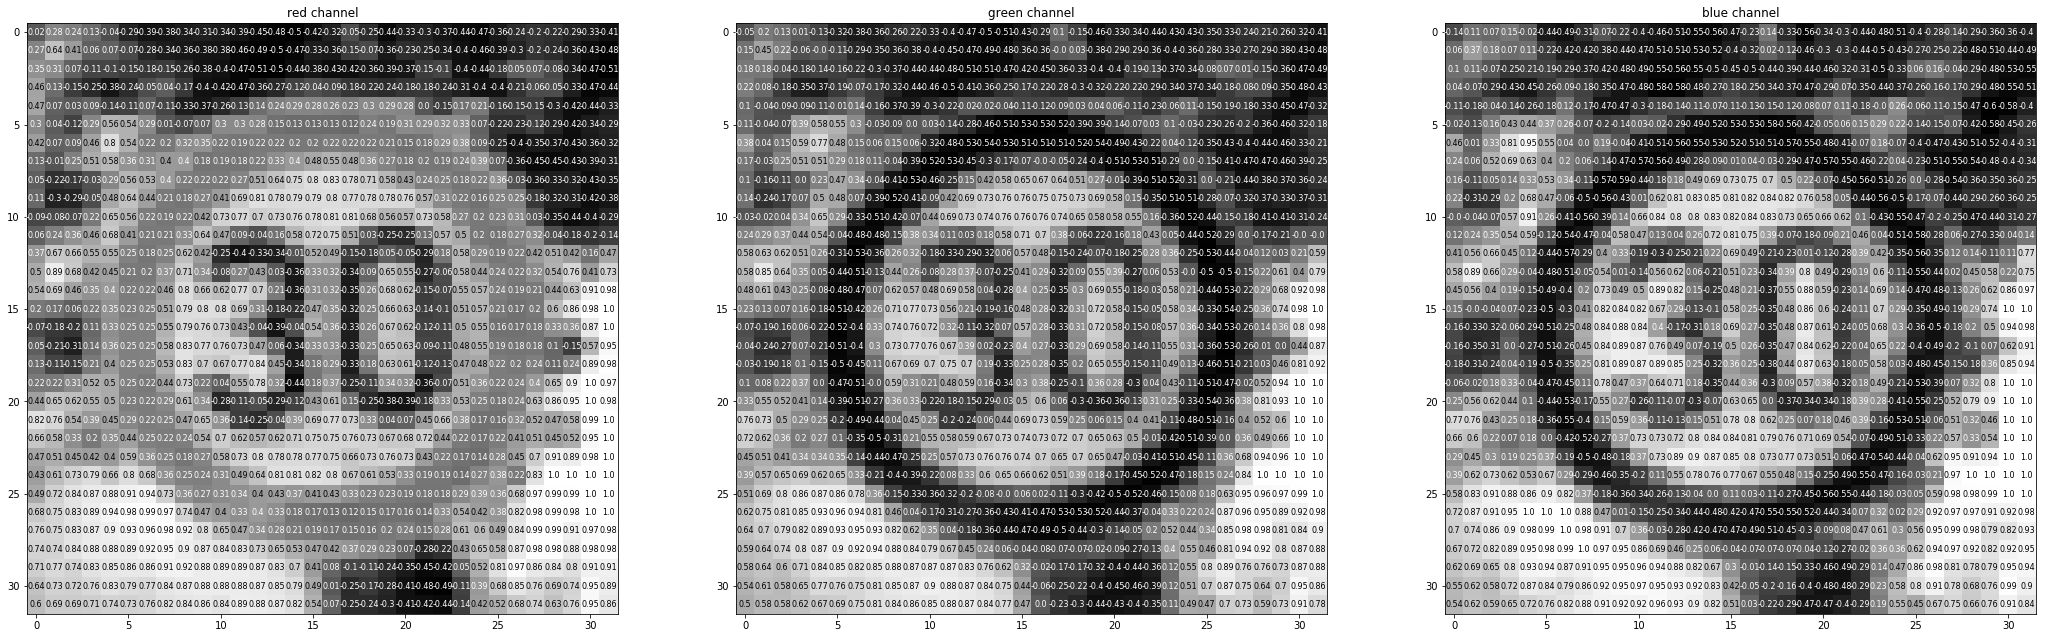

In [23]:
rgb_img = np.squeeze(images[2])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [24]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [103]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> num classes)
        self.fc2 = nn.Linear(500, len(id_label))
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=43, bias=True)
  (dropout): Dropout(p=0.5)
)


In [104]:
import torch.optim as optim
## TODO: Specify loss and optimization functions
from torch import nn, optim
#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

In [105]:
# number of epochs to train the model
import datetime
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
train_losses = list(0. for i in range(n_epochs))
valid_losses = list(0. for i in range(n_epochs))
time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
filename = 'model_augmented_traffic_sign_'+time+'.pt'
filename

'model_augmented_traffic_sign_2019_02_14_23_59_50.pt'

In [106]:

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    train_losses[epoch-1] = train_loss
    valid_losses[epoch-1] = valid_loss
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), filename)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.769007 	Validation Loss: 1.969252
Validation loss decreased (inf --> 1.969252).  Saving model ...
Epoch: 2 	Training Loss: 1.386718 	Validation Loss: 1.137871
Validation loss decreased (1.969252 --> 1.137871).  Saving model ...
Epoch: 3 	Training Loss: 0.830989 	Validation Loss: 0.815564
Validation loss decreased (1.137871 --> 0.815564).  Saving model ...
Epoch: 4 	Training Loss: 0.572083 	Validation Loss: 0.631722
Validation loss decreased (0.815564 --> 0.631722).  Saving model ...
Epoch: 5 	Training Loss: 0.435393 	Validation Loss: 0.554467
Validation loss decreased (0.631722 --> 0.554467).  Saving model ...
Epoch: 6 	Training Loss: 0.342068 	Validation Loss: 0.427402
Validation loss decreased (0.554467 --> 0.427402).  Saving model ...
Epoch: 7 	Training Loss: 0.276642 	Validation Loss: 0.443758
Epoch: 8 	Training Loss: 0.239722 	Validation Loss: 0.397927
Validation loss decreased (0.427402 --> 0.397927).  Saving model ...
Epoch: 9 	Training Loss: 0.207853 

In [65]:
model.load_state_dict(torch.load(filename))

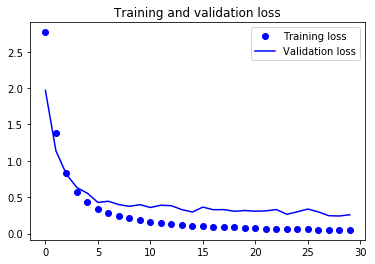

In [107]:
import matplotlib.pyplot as plt
epochs = range(0,len(train_losses))
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [108]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(id_label)))
class_total = list(0. for i in range(len(id_label)))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[int(label)] += correct[i].item()
        class_total[int(label)] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(id_label)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            id_label[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (id_label[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.269838

Test Accuracy of Speed limit (20km/h): 73% (44/60)
Test Accuracy of Speed limit (30km/h): 97% (701/720)
Test Accuracy of Speed limit (50km/h): 97% (734/750)
Test Accuracy of Speed limit (60km/h): 89% (404/450)
Test Accuracy of Speed limit (70km/h): 94% (625/660)
Test Accuracy of Speed limit (80km/h): 89% (565/630)
Test Accuracy of End of speed limit (80km/h): 86% (130/150)
Test Accuracy of Speed limit (100km/h): 83% (377/450)
Test Accuracy of Speed limit (120km/h): 95% (431/450)
Test Accuracy of No passing: 98% (472/480)
Test Accuracy of No passing for vehicles over 3.5 metric tons: 99% (655/660)
Test Accuracy of Right-of-way at the next intersection: 94% (398/420)
Test Accuracy of Priority road: 98% (677/690)
Test Accuracy of Yield: 99% (716/720)
Test Accuracy of  Stop: 100% (270/270)
Test Accuracy of No vehicles: 99% (209/210)
Test Accuracy of Vehicles over 3.5 metric tons prohibited: 100% (150/150)
Test Accuracy of No entry: 90% (326/360)
Test Accuracy of Genera